# Direct Comparison of Quantum 3SAT algorithm and classical counterpart.  

## Shared functions/dependencies 

In [1]:
# Needed for functions
import time
import numpy as np
from numpy import pi
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random

#import packages for classical algorithm
import ctypes
from numpy import ctypeslib as npct

#import packages for quantum algorithm
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import qiskit.quantum_info as qi


from qiskit import Aer, transpile
# import qiskit.providers.aer
from qiskit_aer import AerError

Build 3SAT instance with only one solution

In [2]:
# def buildSatSingleSolution(numVar):
#     sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3]]
#     for n in range(4,numVar+1):
#         sat.append([-2,-3,-n])
#         sat.append([2,3,-n])
#         sat.append([-2,-3,n])
#     return sat

def buildSatSingleSolution(numVar):
    sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3]]
    for n in range(4,numVar+1):
        sat.append([2,3,n])
        sat.append([-2,-3,-n])
        sat.append([-2,-3,n])
        
    return sat

## Stochastic algorithm

Get c++ function to run stochastic algorithm

In [3]:
#initialize variables for classical solver
array_1d_double = npct.ndpointer(dtype=np.double, ndim=1, flags='CONTIGUOUS')
array_1d_int = npct.ndpointer(dtype=np.int_, ndim=1, flags='CONTIGUOUS')

c_lib_numpy = npct.load_library("lib/SATProbCalc.so", ".")

c_lib_numpy.SolveSATbpp.restype = ctypes.c_int #ctypes.POINTER(ctypes.c_double * (10**2))
c_lib_numpy.SolveSATbpp.argtypes = [ctypes.c_int, array_1d_double, ctypes.c_int, ctypes.c_int]

c_lib_numpy.Shoning.restype = ctypes.c_int #ctypes.POINTER(ctypes.c_double * (10**2))
c_lib_numpy.Shoning.argtypes = [ctypes.c_int, array_1d_double, ctypes.c_int, ctypes.c_int]

def SolveSATbpp(n, sat, clauses, iterations):
    steps = c_lib_numpy.SolveSATbpp(n, sat.flatten(), clauses, iterations)
    return steps

def Shoning(n, sat, clauses, iterations):
    steps = c_lib_numpy.Shoning(n, sat.flatten(), clauses, iterations)
    return steps

Functions for getting probability of finding solution with stochastic algorithm

In [4]:
def classicalStatistics(n, SAT, c, i, numRuns):
    stepList = []
    for x in range(numRuns):
        stepList.append(SolveSATbpp(n, SAT, c, i))
#     counter = Counter(stepList)
#     res = {item: count for item, count in counter.items()}
#     print(res)
    return stepList

def classicalStatisticsS(n, SAT, c, i, numRuns):
    stepList = []
    for x in range(numRuns):
        stepList.append(Shoning(n, SAT, c, i))
#     counter = Counter(stepList)
#     res = {item: count for item, count in counter.items()}
#     print(res)
    return stepList

def classicalSolve2(n,SAT,c,i,numIt):

    SAT = np.array(SAT).astype('double')
#     for x in range(len(SAT)):
#         SAT[x] = -SAT[x]

    start = time.time()
    res = classicalStatistics(n, SAT, c, i, numIt)
    print("C++ time to solve: " , start - time.time())

    return res

def classicalSolveS(n,SAT,c,i,numIt):

    SAT = np.array(SAT).astype('double')
#     for x in range(len(SAT)):
#         SAT[x] = -SAT[x]

    start = time.time()
    res = classicalStatisticsS(n, SAT, c, i, numIt)
    print("C++ time to solve: " , start - time.time())

    return res

def classicalSolve(n,SAT,c,i,numIt):

    SAT = np.array(SAT).astype('double')
#     for x in range(len(SAT)):
#         SAT[x] = -SAT[x]
    # print(SAT)

    start = time.time()
    res = classicalStatistics(n, SAT, c, i, numIt)
    print("C++ time to solve: " , start - time.time())

    return res

## Quantum algorithm

Helper functions / gates

In [5]:
def OR(a,b,c,d,e,circuit):
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.x(e)
    circuit.reset(d)

def AND(a,b,c,d,e,circuit):
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.reset(d)
    
def had3(e,a,b,c,circuit,par):
    circuit.ch(e,abs(a)-1)
    circuit.ch(e,abs(b)-1)
    circuit.ch(e,abs(c)-1)
    
def hadAll(e,a,b,c,circuit,par):
    for b in range(par['nQ']):
        circuit.ch(e,b)
#     circuit.ch(e,abs(a)-1)
#     circuit.ch(e,abs(b)-1)
#     circuit.ch(e,abs(c)-1)
    
        
def remStates(a,b,c,d,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
    
    circuit.rcccx(abs(a)-1,abs(b)-1,abs(c)-1,d)
        
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
         
def endRem(a,b,c,d,e,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
        
def qft3(c,q1,q2,q3):
    c.h(abs(q3)-1)
    c.cp(pi/4, abs(q1)-1, abs(q3)-1)
    c.cp(pi/2, abs(q2)-1, abs(q3)-1)
    c.h(abs(q2)-1)
    c.cp(pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q1)-1)
    c.swap(abs(q1)-1,abs(q3)-1)
    
def qft3i(c,q1,q2,q3):
    c.swap(abs(q1)-1,abs(q3)-1)
    c.h(abs(q1)-1)
    c.cp(-pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q2)-1)
    c.cp(-pi/2, abs(q2)-1, abs(q3)-1)
    c.cp(-pi/4, abs(q1)-1, abs(q3)-1)
    c.h(abs(q3)-1)

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n, s):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[s:n+s])
    return circuit.decompose() # .decompose() allows us to see the individual gates
    

Build quantum circuit

In [6]:
# SAT problem that will be implemented in circuit
# sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3],[-2,-3,4],[-2,-3,-4],[-2,-3,5],[-2,-3,-5],[-2,-3,6],[-2,-3,-6],[-2,-3,7],[-2,-3,-7],[2,3,4],[2,3,5],[2,3,6],[2,3,7]]

def buildCircuit(par,measure):
    helper = 1 #number of ancillary qubits
    h = par['nQ'] #qubit that can be used for calculations

    qr = QuantumRegister(par['nQ']+helper, 'q')
    cr = ClassicalRegister(par['nQ'], 'c')
    c = QuantumCircuit(qr, cr)

    # Hadimard all qubits used in SAT
    if par['had']:
        for x in range(par['nQ']):
            c.h(x)
                
    for n in range(par['numIt']): # Repeat circuit numIt times
#         random.shuffle(par['sat'])
        for clause in par['sat']: # loop through all clauses in the SAT instance
            
            
            remStates(clause[0],clause[1],clause[2],h,c)
            had3(h,clause[0],clause[1],clause[2],c,par)
            c.reset(h)
            
            c.barrier(qr)  
            
    if measure:
        c.measure(qr[:-1],cr)
            
    return c

## Exhaustive search for solution

Helper functions for classical exhaustive search of solutions to SAT instance

In [7]:
def checkSAT(SAT, state, c, n):
        
    for t in range(c):
        # //get the variables the clause is interested in
        seive = (1 << (abs(int(SAT[t][0])) - 1)) + (1 << (int(abs(SAT[t][1])) - 1)) + (1 << (int(abs(SAT[t][2])) - 1))
        # //get the values in the clause to xor
        gate = 0
            
        if (SAT[t][0] > 0):
            gate += 1 << (abs(int((SAT[t][0]))) - 1)
        if (SAT[t][1] > 0):
            gate += 1 << (abs(int((SAT[t][1]))) - 1)
        if (SAT[t][2] > 0):
            gate += 1 << (abs(int((SAT[t][2]))) - 1)

        a = seive & state
        b = gate ^ a

        if (b == 0):
            return False
    return True

def exhausting(SAT,c,n):
    solutions = []
#     for t in range(c):
#         print((int(SAT[t][0]))," ",(int(SAT[t][1]))," ",(int(SAT[t][2])))
    
    for s in range(0,2**n):
        state = int(s)
        if(checkSAT(SAT, state, c, n)):
            solutions.append(state)
    return solutions
            

In [8]:
# SAT = buildSatSingleSolution(n)
# # random.shuffle(SAT)
# solutions = exhausting(SAT,c,n)
# print(solutions)

# myKeys = list(res.keys())
# myKeys.sort()
# sorted_dict = {i: res[i] for i in myKeys}
 
# print(sorted_dict)
# plt.plot(list(map(int,sorted_dict.keys())),sorted_dict.values())

# Test and compare quantum and classical algorithms

In [9]:
def setup(nQ):
    par = {}
    par['nQ'] = nQ
    par['sat'] = buildSatSingleSolution(par['nQ'])
    par['numIt'] = len(par['sat'])

    #Plotting Conditionals
    par['latex'] = True
    par['statevector'] = True
    par['saveEnd'] = False
    par['figName'] = "Plots/TestSave2/{:0>6}.png"
    
    par['measure'] = False
    par['had'] = True
    
    par['gpu'] = False
    
#     print(par['numIt'])
    
    state = ''
    for q in range(nQ):
        state = state + '0'
    par['state'] = state
    
    return par

Initialize parameters for SAT instance

In [16]:
n = 6
par = setup(n)

# c = 3*n -2
c = len(par['sat'])

i = 10000
numIt = 10000000

Run statistical test of modified Shonings algorithm

In [17]:
res = classicalSolve2(n,par['sat'],c,i,numIt)

values, base = np.histogram(res, bins=n**2)
#evaluate the cumulative
cumulative = np.cumsum(values)

C++ time to solve:  -93.7524266242981


Run statistical test of regular Shonings algorithm

In [18]:
resS = classicalSolveS(n,par['sat'],c,i,numIt)

valuesS, baseS = np.histogram(resS, bins=n**2)
#evaluate the cumulative
cumulativeS = np.cumsum(valuesS)

C++ time to solve:  -101.74362564086914


In [13]:
solutions = exhausting(par['sat'],c,n)
print(solutions)

[7]


Run test of quantum algorithm

Iteration 1 took -0.2968299388885498
Iteration 2 took -0.5843992233276367
Iteration 3 took -0.8523788452148438
Iteration 4 took -1.1181681156158447
Iteration 5 took -1.3948698043823242
Iteration 6 took -1.6542940139770508
Iteration 7 took -1.9569191932678223
Iteration 8 took -2.260615587234497
Iteration 9 took -2.4484012126922607
Iteration 10 took -2.7094526290893555
Iteration 11 took -2.9830894470214844
Iteration 12 took -3.2484753131866455
Iteration 13 took -3.5669031143188477
Iteration 14 took -3.8368730545043945
Iteration 15 took -4.069310903549194
Iteration 16 took -4.320018529891968
Iteration 17 took -4.6621599197387695
Iteration 18 took -5.097837209701538
Iteration 19 took -5.212967395782471
Iteration 20 took -5.430892705917358
Iteration 21 took -5.669378280639648
Iteration 22 took -5.895241737365723
Iteration 23 took -6.226404428482056
Iteration 24 took -6.42212176322937
Iteration 25 took -6.819354295730591
Iteration 26 took -6.994826316833496
Iteration 27 took -7.2128019332885

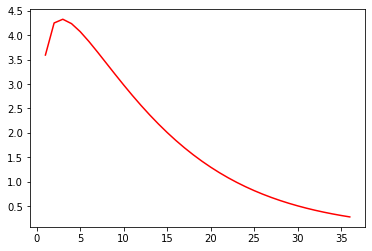

In [14]:
maxIt = n**2
probList = []
entropyList = []
xs = np.linspace(1,maxIt,num = maxIt,dtype='int')

if par['gpu']:
    # Initialize a GPU backend
    # Note that the cloud instance for tutorials does not have a GPU
    # so this will raise an exception.
    try:
        simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
        simulator_density_matrix.set_options(device='GPU')
    except AerError as e:
        print(e)
        
    for it in xs:
        par['numIt']  = it
        shots = 10000

        # Build circuit
        start = time.time()
        qc = buildCircuit(par,True)
        circ = transpile(qc, simulator_density_matrix, optimization_level=0)
        job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
        counts_density_matrix = job_density_matrix.result().get_counts(0)

        print("Iteration " + str(it) + " took " + str(start-time.time()))

        total = 0
        for state in counts_density_matrix:
            if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
                total += counts_density_matrix[state]

        probList.append(total/shots)
else:
    for it in xs:
        par['numIt']  = it

        # Build circuit
        start = time.time()
        qc = buildCircuit(par,False)

        if(par['statevector']):
            # Execute and get counts
            DM = qi.DensityMatrix.from_instruction(qc)
            # probs = DM.probabilities_dict()
            DM2 = qi.partial_trace(DM,[par['nQ']])
            probs = DM2.probabilities_dict()
            entropyList.append(qi.entropy(DM2))

        print("Iteration " + str(it) + " took " + str(start-time.time()))

        names = list(probs.keys())
        values = list(probs.values())

        totalProb = 0
        for s in solutions:
            totalProb += list(probs.values())[s]
        probList.append(totalProb)
    
    plt.plot(xs, entropyList, c='red')
    

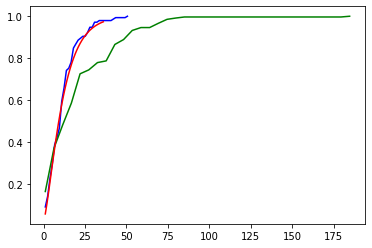

In [27]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(baseS[:-1]+1, cumulativeS/numIt, c='green')
plt.plot(xs, probList, c='red')

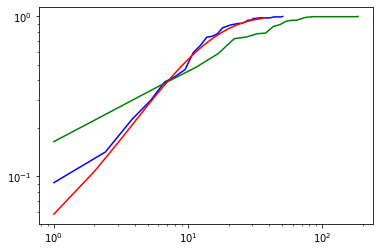

In [26]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(baseS[:-1]+1, cumulativeS/numIt, c='green')
plt.plot(xs, probList, c='red')
plt.xscale('log')
plt.yscale('log')

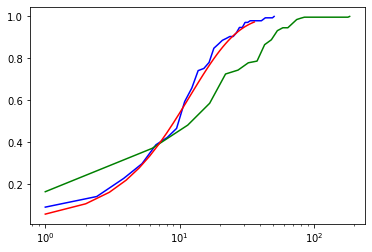

In [29]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(baseS[:-1]+1, cumulativeS/numIt, c='green')
plt.plot(xs, probList, c='red')
plt.xscale('log')